<font size="10">Learning Transformations to Saddle-Node Normal Forms</font>

<font size="4">In this notebook we train an autoencoder neural network architecture to identify a change of variable from the nonlinear mapping $x_{n+1} = (1 + \mu)x_n - \mathrm{e}^{x_n}$ to the normal form of the saddle-node bifurcation, $y_{n+1} = \nu + y_n + y_n^2$. The transformation is local to the bifurcation point $(x,\mu) = (1,\mathrm{e})$ and is approximated by the encoder $\eta(x,\mu)$ with the inverse transformation approximated by the decoder $\rho(y,\nu)$.</font>

<font size="4">At the end of this notebook and in the accompanying MATLAB script make_plots.m we use this local conjugacy to produce a local bifurcation diagram in the $(\mu,x)$ plane for the saddle-node bifurcation. This is compared to the Taylor expansion of the bifurcating fixed points. Moreover, since conjugacies preserve stability properties of maps, the bifurcation diagram also includes stability, induced from the stability of the branches in the normal form.</font>

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 6.3 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [137]:
# Sample random points in the (x,mu) domain
N = 5000 # number of samples
xn = np.zeros((N,2)) # Augmented to include state x_n and parameter mu
xnp1 = np.zeros((N,2))

for n in range(1,N):
    xn[n,0] = np.random.rand(1) - 0.5
    xn[n,1] = 0.4*np.random.rand(1) - 0.2
xnp1[:,0] = xn[:,0] + np.multiply(xn[:,1] + np.exp(1), xn[:,0] + 1) - np.exp(xn[:,0] + 1) # forward iterate of the nonlinear map
xnp1[:,1] = xn[:,1]

In [145]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 2,
                 size_y = 2,
                 activation = 'selu',
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.numblksIn = numblksIn
    self.numblksOut = numblksOut
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Encoder function 
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to logistic map variables
    self.encoder.add(layers.Dense(self.size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function
    self.decoder = tf.keras.Sequential()
    
    for n in range(self.numblksOut): #adding more layers
        self.decoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to tent map variables 
    self.decoder.add(tf.keras.layers.Dense(self.size_x, activation= self.activation, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    
    # Apply encoder/conjugacy
    encoded = self.encoder(x)
    
    # Build forward iterates under normal form
    ynp1 = encoded[:,0] + encoded[:,1] + tf.square(encoded[:,0]) # Saddle-node normal form
    munp1 = encoded[:,1] # parameter step
    encoded_p1 = tf.stack([ynp1, munp1], axis = -1)
    decoded = self.decoder(encoded_p1)
    
    # Encoder/Decoder loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x - x_recon)))
    
    # f = rho of g of eta loss
    xnp1_1 = x[:,0] + tf.multiply(x[:,1] + tf.math.exp(1.0), x[:,0] + 1) - tf.math.exp(x[:,0] + 1) # forward iterate of the quadratic map
    xnp1_2 = x[:,1]
    xnp1 = tf.stack([xnp1_1, xnp1_2], axis = -1)
    self.add_loss(tf.reduce_mean(tf.math.square(decoded - xnp1)))
    
    # Normal form loss
    xnp1_encoded = self.encoder(xnp1)
    self.add_loss(tf.reduce_mean(tf.math.square(encoded_p1 - xnp1_encoded)))
    
    # Enforce bifurcation point
    self.add_loss(tf.reduce_mean(tf.math.square(self.encoder(0*x))))

    return decoded

In [146]:
width = 100 # width of each NN layer
size_x = 2 # number of variables in the nonlinear exponential map (state + parameter)
size_y = 2 # number of variables in the normal form (state + parameter)
activation = 'selu' # nonlinear activation function at each NN layer
learning_rate = 0.0001
numblks_in = 2 # number of layers for the encoder NN
numblks_out = 2 # number of layers for the decoder NN

In [147]:
conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in, numblks_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 100)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

conjugacy.fit(xn, xnp1, callbacks = [callback], epochs = 5000)

Epoch 1/5000
157/157 [==============================] - 2s 2ms/step - loss: 0.0605
Epoch 2/5000
157/157 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 3/5000
157/157 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 4/5000
157/157 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 5/5000
157/157 [==============================] - 0s 2ms/step - loss: 9.2532e-04
Epoch 6/5000
157/157 [==============================] - 0s 2ms/step - loss: 7.2095e-04
Epoch 7/5000
157/157 [==============================] - 0s 2ms/step - loss: 5.4809e-04
Epoch 8/5000
157/157 [==============================] - 0s 1ms/step - loss: 4.3295e-04
Epoch 9/5000
157/157 [==============================] - 0s 2ms/step - loss: 3.4450e-04
Epoch 10/5000
157/157 [==============================] - 0s 2ms/step - loss: 2.9008e-04
Epoch 11/5000
157/157 [==============================] - 0s 2ms/step - loss: 2.5205e-04
Epoch 12/5000
157/157 [==============================] - 

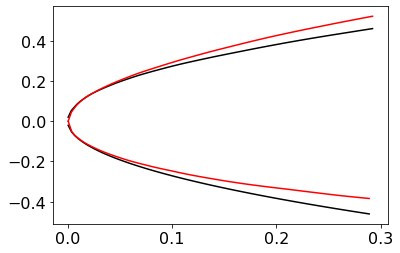

In [160]:
# View trained network

# Check where fixed points in the normal form go to
sn_fixed_u = np.zeros((100,2)) # Unstable fixed point in normal form
sn_fixed_s = np.zeros((100,2)) # Stable fixed point in normal form
for n in range(100):
    sn_fixed_u[n,1] = -0.5*n/100
    sn_fixed_s[n,1] = sn_fixed_u[n,1]
    sn_fixed_u[n,0] = np.sqrt(-sn_fixed_u[n,1])
    sn_fixed_s[n,0] = -np.sqrt(-sn_fixed_u[n,1])  
    
# Decode normal form fixed points    
fixed_u = conjugacy.decoder(sn_fixed_u)
fixed_s = conjugacy.decoder(sn_fixed_s)

# Taylor expansion of fixed point values
true_fixed_u = -tf.sqrt(2*fixed_u[:,1]/tf.math.exp(1.0))
true_fixed_s = tf.sqrt(2*fixed_u[:,1]/tf.math.exp(1.0))

# Plot Taylor expansion of fixed points in bifurcation diagram
plt.plot(fixed_u[:,1],true_fixed_u,'k')
plt.plot(fixed_s[:,1],true_fixed_s,'k')

# Plot results
plt.plot(fixed_u[:,1],fixed_u[:,0],'r')
plt.plot(fixed_s[:,1],fixed_s[:,0],'r')

In [158]:
# Save network config
#!mkdir -p saved_conjugacy_networks
conjugacy.save('saved_conjugacy_networks/saddle_node')

INFO:tensorflow:Assets written to: saved_conjugacy_networks/saddle_node/assets


In [159]:
# Output to MATLAB
import scipy.io

# Save data as .mat file
scipy.io.savemat('saddle_node.mat', dict(fixed_u = fixed_u.numpy(), fixed_s = fixed_s.numpy()))
# This data is used in the MATLAB script make_plots.m to plot the bifurcation diagrams